In [25]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, LogisticRegression

pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_seq_items', None)
 
#%config InlineBackend.figure_formats = {'pdf',}
%matplotlib inline

import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

In [26]:
# Using write.csv in R, I exported the dataset from package 'ISLR' to a csv file
df = pd.read_csv('Data/Wage.csv')
df.head(3)

   Unnamed: 0  year  age      sex            maritl      race  \
0      231655  2006   18  1. Male  1. Never Married  1. White   
1       86582  2004   24  1. Male  1. Never Married  1. White   
2      161300  2003   45  1. Male        2. Married  1. White   

         education              region        jobclass          health  \
0     1. < HS Grad  2. Middle Atlantic   1. Industrial       1. <=Good   
1  4. College Grad  2. Middle Atlantic  2. Information  2. >=Very Good   
2  3. Some College  2. Middle Atlantic   1. Industrial       1. <=Good   

  health_ins   logwage        wage  
0      2. No  4.318063   75.043154  
1      2. No  4.255273   70.476020  
2     1. Yes  4.875061  130.982177  

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 0 to 2999
Data columns (total 13 columns):
Unnamed: 0    3000 non-null int64
year          3000 non-null int64
age           3000 non-null int64
sex           3000 non-null object
maritl        3000 non-null object
race          3000 non-null object
education     3000 non-null object
region        3000 non-null object
jobclass      3000 non-null object
health        3000 non-null object
health_ins    3000 non-null object
logwage       3000 non-null float64
wage          3000 non-null float64
dtypes: float64(2), int64(3), object(8)
memory usage: 234.4+ KB


### Figure 7.1

In [28]:
poly = PolynomialFeatures(4)
X = poly.fit_transform(df.age.reshape(-1,1))
y = (df.wage > 250).map({False:0, True:1}).as_matrix()
print('X:\n', X[:5])
print('y:\n', y[:5])

X:
 [[      1      18     324    5832  104976]
 [      1      24     576   13824  331776]
 [      1      45    2025   91125 4100625]
 [      1      43    1849   79507 3418801]
 [      1      50    2500  125000 6250000]]
y:
 [0 0 0 0 0]


In [29]:
clf = LogisticRegression()
clf.fit(X,y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [30]:
# Create array of test data. Transform to polynomial degree 4.
X_test = poly.fit_transform(np.arange(df.age.min(), df.age.max()).reshape(-1,1))
X_test[:5]

array([[     1,     18,    324,   5832, 104976],
       [     1,     19,    361,   6859, 130321],
       [     1,     20,    400,   8000, 160000],
       [     1,     21,    441,   9261, 194481],
       [     1,     22,    484,  10648, 234256]])

In [31]:
prob = clf.predict_proba(X_test)
# Class probabilities of 'False' and 'True'
prob[:5]

array([[ 0.9172245 ,  0.0827755 ],
       [ 0.9290432 ,  0.0709568 ],
       [ 0.93896616,  0.06103384],
       [ 0.94725434,  0.05274566],
       [ 0.95414963,  0.04585037]])

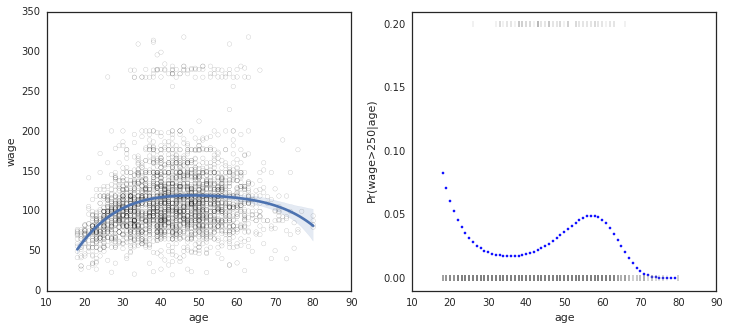

In [32]:
# creating plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))

# Scatter plot with polynomial regression line
ax1.scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.3)
sns.regplot(df.age, df.wage, order = 4, truncate=True, scatter=False, ax=ax1)
ax1.set_ylim(ymin=0)

# Logistic regression showing Pr(wage>250) for the age range.
ax2.scatter(np.arange(df.age.min(), df.age.max()).reshape(-1,1), prob[:,1], color='b', s=5)
# Rug plot showing the distribution of wage>250 in the training data.
# 'True' on the top, 'False' on the bottom.
ax2.scatter(df.age, y/5, s=30, c='grey', marker='|', alpha=0.7)

ax2.set_ylim(-0.01,0.21)
ax2.set_xlabel('age')
ax2.set_ylabel('Pr(wage>250|age)')

Something is wrong with the logistic regression. Below a distribution plot of the ages from the training data where 'wage > 250'.

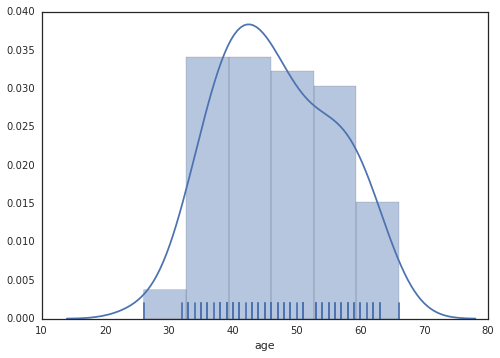

In [33]:
sns.distplot(df.age[df.wage > 250], rug=True)